In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, ifftshift

import warnings
warnings.filterwarnings("ignore")

In [2]:
def scale_down(image, resize_ratio):
    f_transform = fft2(image)
    f_transform = fftshift(f_transform)

    # 0 < ratio < 1
    new_h, new_w = int(image.shape[0] * resize_ratio), int(image.shape[1] * resize_ratio)
    center_h, center_w = f_transform.shape[0] // 2, f_transform.shape[1] // 2

    # crop the frequency spectrum
    cropped_transform = f_transform[center_h - new_h // 2:center_h + new_h // 2, 
                                    center_w - new_w // 2:center_w + new_w // 2]
    
    # after cropping, inverse fft
    downscaled_image = np.abs(ifft2(ifftshift(cropped_transform)))
    return downscaled_image

In [3]:
def scale_up(image, resize_ratio):
    f_transform = fft2(image)
    f_transform = fftshift(f_transform)

    # ratio > 1
    new_h, new_w = int(image.shape[0] * resize_ratio), int(image.shape[1] * resize_ratio)
    center_h, center_w = f_transform.shape[0] // 2, f_transform.shape[1] // 2

    # define the wanted image size
    expanded_transform = np.zeros((new_h, new_w), dtype=complex)

    orig_h, orig_w = f_transform.shape
    orig_center_h, orig_center_w = orig_h // 2, orig_w // 2

    # copy the fourier spectrum to the scaled up image, from the center
    expanded_transform[center_h - orig_center_h:center_h + orig_center_h,
                       center_w - orig_center_w:center_w + orig_center_w] = f_transform
    
    # shift back to 0,0 and inverse fft
    expanded_spectrum = ifftshift(expanded_spectrum)
    scaled_up_image = np.abs(ifft2(expanded_spectrum))
    
    return scaled_up_image

In [4]:
def ncc_2d(image, pattern):
    windows = np.lib.stride_tricks.sliding_window_view(image, pattern.shape)

    window_means = np.mean(windows, axis=(-2, -1))
    pattern_mean = np.mean(pattern)

    numerator = np.sum((windows - window_means[..., None, None])
                       * (pattern - pattern_mean), axis=(-2, -1))
    
    # The denominator is essentially std sums of each window and pattern
    window_stds = np.std(windows, axis=(-2, -1))
    pattern_std = np.std(pattern)

    denominator = window_stds * pattern_std

    ncc = np.zeros_like(denominator)
    valid_mask = denominator != 0                                      # Mask for non-zero denominators
    ncc[valid_mask] = numerator[valid_mask] / denominator[valid_mask]  # Compute NCC only where denominator is not 0

    return ncc


In [5]:
def display(image, pattern):
	
	plt.subplot(2, 3, 1)
	plt.title('Image')
	plt.imshow(image, cmap='gray')
		
	plt.subplot(2, 3, 3)
	plt.title('Pattern')
	plt.imshow(pattern, cmap='gray', aspect='equal')
	
	ncc = ncc_2d(image, pattern)
	
	plt.subplot(2, 3, 5)
	plt.title('Normalized Cross-Correlation Heatmap')
	plt.imshow(ncc ** 2, cmap='coolwarm', vmin=0, vmax=1, aspect='auto') 
	
	cbar = plt.colorbar()
	cbar.set_label('NCC Values')
		
	plt.show()

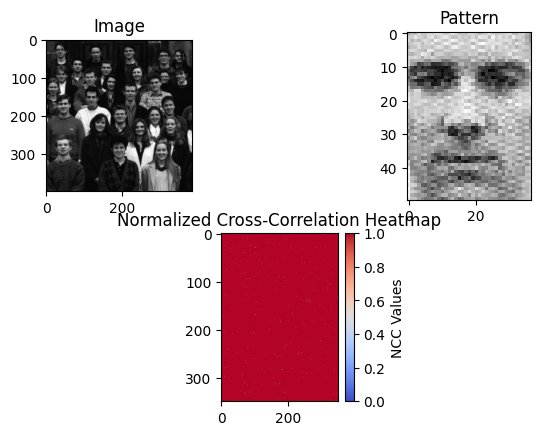

In [6]:
def draw_matches(image, matches, pattern_size):
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	for point in matches:
		y, x = point
		top_left = (int(x - pattern_size[1]/2), int(y - pattern_size[0]/2))
		bottom_right = (int(x + pattern_size[1]/2), int(y + pattern_size[0]/2))
		cv2.rectangle(image, top_left, bottom_right, (255, 0, 0), 1)
	
	plt.imshow(image, cmap='gray')
	plt.show()
	
	cv2.imwrite(f"{CURR_IMAGE}_result.jpg", image)


CURR_IMAGE = "students"

image = cv2.imread(f'{CURR_IMAGE}.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

pattern = cv2.imread('template.jpg')
pattern = cv2.cvtColor(pattern, cv2.COLOR_BGR2GRAY)

############# DEMO #############
display(image, pattern)

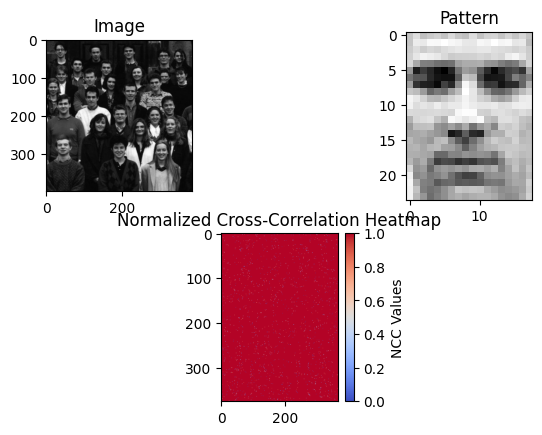

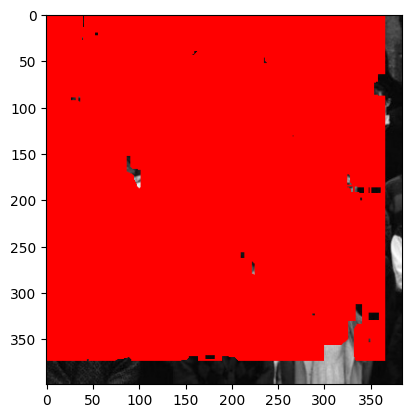

In [12]:
############# Students #############
image_scaled = image
pattern_scaled =  scale_down(pattern, 0.5)

display(image_scaled, pattern_scaled)

ncc = ncc_2d(image, pattern)
threshold = 0.7  # **Added a threshold for match selection**
real_matches = np.argwhere(ncc >= threshold)

######### DONT CHANGE THE NEXT TWO LINES #########
real_matches[:,0] += pattern_scaled.shape[0] // 2			# if pattern was not scaled, replace this with "pattern"
real_matches[:,1] += pattern_scaled.shape[1] // 2			# if pattern was not scaled, replace this with "pattern"

# If you chose to scale the original image, make sure to scale back the matches in the inverse resize ratio.

draw_matches(image, real_matches, pattern_scaled.shape)	# if pattern was not scaled, replace this with "pattern"

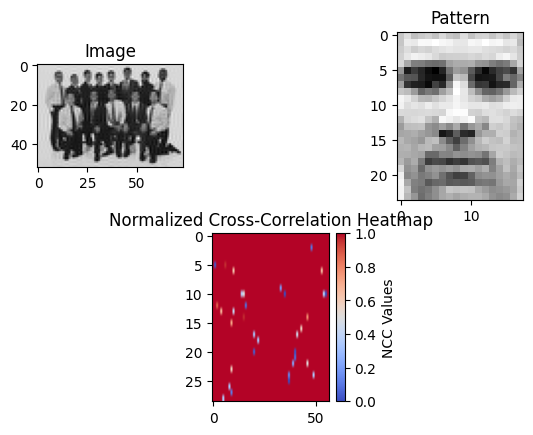

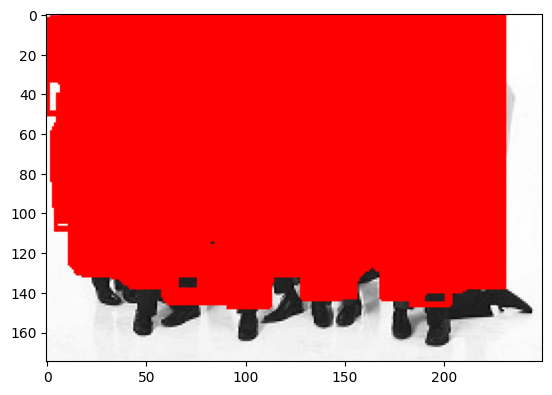

In [18]:
CURR_IMAGE = "thecrew"
image = cv2.imread(f'{CURR_IMAGE}.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


############# Crew #############

image_scaled = scale_down(image, 0.3)
pattern_scaled = scale_down(pattern, 0.5)

display(image_scaled, pattern_scaled)

ncc = ncc_2d(image, pattern)
threshold = 0.7  # **Added a threshold for match selection**
real_matches = np.argwhere(ncc >= threshold)

######### DONT CHANGE THE NEXT TWO LINES #########
real_matches[:,0] += pattern_scaled.shape[0] // 2			# if pattern was not scaled, replace this with "pattern"
real_matches[:,1] += pattern_scaled.shape[1] // 2			# if pattern was not scaled, replace this with "pattern"

# If you chose to scale the original image, make sure to scale back the matches in the inverse resize ratio.

draw_matches(image, real_matches, pattern_scaled.shape)	# if pattern was not scaled, replace this with "pattern"